# Notebook

In this assignment you will start with modeling potential performance gains of quantization on a hypothetical architecture.
Then, you will quantize VGG16 using static, post-training quantization tools provided by PyTorch. Finally, you will benchmark
your performance on a server CPU and show the impact of quantization on runtime.

## Environment

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import time
from torchvision import datasets, models, transforms
from pathlib import Path
import math
import matplotlib.pyplot as plt

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')

torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [2]:
# Mount data directory to google drive
from google.colab import drive

# Copy to local for faster extraction
drive.mount('/content/drive')
!cp /content/drive/Shareddrives/539/ILSVRC2012_img_val.tar ./data
!cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t3.tar.gz ./data
!cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t12.tar.gz ./data
print('Finished copying from Drive to local.')

Mounted at /content/drive
Finished copying from Drive to local.


In [3]:
# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, num_workers=2)

print(f'Number of validation images: {len(val_dataset)}')

Number of validation images: 50000


## Modeling

As discussed in lecture, low precision improves energy and area costs while also improving throughput on capable architectures. In this section,
we will model speedup from low precision number formats on a theoretical architecture.

### Question 1

Given the assumptions below, calculate the execution time (s) of a $N \times N$ matrix multiplication with `FP32`, `FP16`, `INT32`, `INT16`, `INT8` and `INT4`.
* Assume 32 bit architecture that can perform efficiently pack multiple operations for example: 1 FP32 operation or 2 FP16 operations, 8 INT4 operations
* Assume all arithmetic operations (add, multiply) can be executed in one clock cycle
* Multiply and accumulate consists of one add and one multiply
* Loads and stores are free i.e. 0 clock cycles
* Architecture runs at 1 GHz


In [4]:
type_list = ['FP32', 'FP16', 'INT32', 'INT16', 'INT8', 'INT4']

def get_speedupv1(n: int = 4, datatype: str = 'FP32') -> float:
    """ Returns execution time in seconds for a given n and datatype. """
    
    num_multiply = np.power(n,3) #calc number of multiplies
    num_add = (np.power(n,2))*(n-1) # calc number of adds

    if('32' in datatype): c = 1 #setting constants based on size of dt
    if('16' in datatype): c = 2
    if('8' in datatype): c = 4
    if('4' in datatype): c = 8
    
    cycles_multiply = num_multiply/c #scaling based on scaling factor
    cycles_add = num_add/c #scaling based on scaling factor
    
    cycles_multiply = math.ceil(cycles_multiply) #approximating for cycles
    cycles_add = math.ceil(cycles_add) #approximating for cycles
    
    cycles = cycles_multiply + cycles_add #totalling all the cycles
    ans = cycles*(1e-9) # each cycle takes 1ns as the speed is 1GHz, so 1 sec has 10^9 cycles, 1ns has 1 cycle
    return ans

dict_speedupv1 = {}
for datatype in type_list:
    dict_speedupv1[(1024, datatype)] = get_speedupv1(n=1024, datatype=datatype)
    print(f'Modeled execution time for {datatype} is {dict_speedupv1[(1024, datatype)]}s')

Modeled execution time for FP32 is 2.146435072s
Modeled execution time for FP16 is 1.073217536s
Modeled execution time for INT32 is 2.146435072s
Modeled execution time for INT16 is 1.073217536s
Modeled execution time for INT8 is 0.536608768s
Modeled execution time for INT4 is 0.268304384s


### Question 2

Memory performance can also be a performance factor for matrix multiplication. In this question, we assign a cost to
loading memory from storage. 

Given the assumptions below, calculate the execution time (s) of a $N \times N$ matrix multiplication with `FP32`, `FP16`, `INT32`, `INT16`, `INT8` and `INT4`.
* Assume 32 bit architecture that can perform efficiently pack multiple operations for example: 1 FP32 operation or 2 FP16 operations, 8 INT4 operations
* Architecture can perform **either a 32 bit load** or x arithmetic operations depending on datatype each clock cycle
* **32 bit loads are packed with multiple row elements according to the data type**
* Assume all arithmetic operations (add, multiply) and **load operations** can be executed in one clock cycle
* Multiply and accumulate consists of one add and one multiply
* **A column only needs to be loaded once, a row must be loaded once per row selection**
* **Intermediate results of multiply and accumulate do not need to be re-loaded**
* **Stores** are free i.e. 0 clock cycles
* Architecture runs at 1 GHz

In [261]:
def get_speedupv2(n: int = 1024, datatype: str = 'FP32') -> float:
    """ Returns execution time in seconds for a given n and datatype """

    num_loads = 2*np.power(n,2)#calc number of loads
    num_multiply = np.power(n,3)#calc number of multiplies
    num_add = (np.power(n,2))*(n-1)#calc number of adds

    if('32' in datatype): c = 1#setting constants based on size of dt
    if('16' in datatype): c = 2
    if('8' in datatype): c = 4
    if('4' in datatype): c = 8
    
    cycles_multiply = num_multiply/c#scaling based on scaling factor
    cycles_add = num_add/c#scaling based on scaling factor
    cycles_loads = num_loads/c#scaling based on scaling factor
    
    cycles_multiply = math.ceil(cycles_multiply)#approximating for cycles
    cycles_add = math.ceil(cycles_add)#approximating for cycles
    cycles_loads = math.ceil(cycles_loads)#approximating for cycles

    cycles = cycles_multiply + cycles_add + cycles_loads#totalling all the cycles
    ans = cycles*(1e-9)# each cycle takes 1ns as the speed is 1GHz, so 1 sec has 10^9 cycles, 1ns has 1 cycle
    return ans

dict_speedupv2 = {}
for datatype in type_list:
    dict_speedupv2[(1024, datatype)] = get_speedupv2(n=1024, datatype=datatype)
    print(f'Modeled execution time for {datatype} is {dict_speedupv2[(1024, datatype)]}s')

Modeled execution time for FP32 is 2.148532224s
Modeled execution time for INT32 is 2.148532224s
Modeled execution time for INT16 is 1.074266112s
Modeled execution time for INT8 is 0.537133056s


### Question 3

To verify the benefit of reduced precision datatypes, we will run a matrix multiplication benchmark on CPU with the four data types. 
Ensure to follow the same guidelines as in lab 2 including warming up the CPU and performing multiple trials. Use 50 trials and average the performance.

To generate a random tensor with datatype INT8 use `torch.rand(dtype=torch.int8)`. A list of datatypes is found here: [https://pytorch.org/docs/stable/tensors.html](https://pytorch.org/docs/stable/tensors.html).

As not all operators have support for reduced precision, we will use use FP32, INT32, INT16, INT8, and `torch.nn.functional.linear` to perform matrix multiplication. `torch.nn.functional.linear` performs the following function: $y = xA^T+b$ where 
$$
y \in \mathbb{F}^{BatchSize \times n},\;x \in \mathbb{F}^{BatchSize \times m},\;A \in \mathbb{F}^{m\times n}
$$
Therefore, to perform a $N\times N$ matrix multiplication, we just need to set the bias to $0$ and batch size to $N$.

In [6]:
def get_performance(n : int = 1024, datatype: str = 'FP32', device: str = 'cpu') -> float:
    """ Returns execution time in seconds for a given n, datatype and device"""

    temp = []

    #adjusting datatype based on input

    if datatype == 'FP32':
      dt = torch.float32

    if datatype == 'INT32':
      dt = torch.int32

    if datatype == 'INT16':
      dt = torch.int16

    if datatype == 'INT8':
      dt = torch.int8


    #initializing matrices

    A = torch.randint(0,9,size = (n,n), dtype=dt)
    W = torch.randint(0,9,size = (n,n), dtype=dt)


    #moving to device

    A = A.to(device)
    W = W.to(device)

    """
    warmup
    """
    for i in range(10):
      nn.functional.linear(A, W, bias=None)
    
    """
    50 trials
    """
    for i in range(50): #trials for 50
      t1 = time.time()
      nn.functional.linear(A, W, bias=None) #multiplying
      t2 = time.time()
      temp.append(t2-t1)

    ans = sum(temp)/50.0 # calculating average of 50 trials

    # TODO: convert datatype to dtype and run 50 multiplications between two n*n matrices of the dtype
    # return the execution time
    return ans

type_list = ['FP32', 'INT32', 'INT16', 'INT8']
performance = {}
for datatype in type_list:
        for device in ['cpu']:
            performance[(1024, datatype, device)] = get_performance(n=1024, datatype=datatype, device=device)
            print(f'Actual Execution time for {datatype} on {device} is {performance[(1024, datatype, device)]}s')

Actual Execution time for FP32 on cpu is 0.03484700679779053s
Actual Execution time for INT32 on cpu is 0.1948304605484009s
Actual Execution time for INT16 on cpu is 0.6378729295730591s
Actual Execution time for INT8 on cpu is 0.6708712673187256s


### Question 4

Plot the performance for CPU on a bar graph using a plotting tool of your choice.
* Label X and Y axis
* X axis should be the different types
* Y axis should be the `1/runtime`

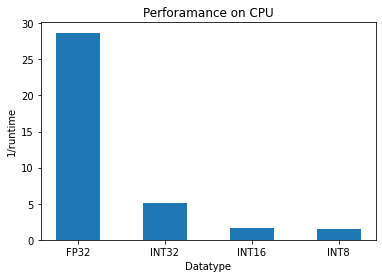

In [271]:
data = performance
temp = list(data.keys())
x = [temp[0][1], temp[1][1], temp[2][1], temp[3][1]]
y = list(data.values())
y = np.reciprocal(y)
plt.bar(x,y, width = 0.5)
plt.xlabel("Datatype")
plt.ylabel("1/runtime")
plt.title("Perforamance on CPU")
plt.show()

Write one paragraph describing the results of the question 3 benchmark. Are there any behaviors of note? Why do you think those behaviors exist?

**TODO**
<br> The results in the q3 benchmark indicate that lower precision datatypes have slower execution that is higher runtime and hence lower y value in the graph (1/runtime). As the precision reduces, the results show that it takes more time to run.<br> The execution time in general is highily dependent on the memory bandwith and bytes accessed per unit bandwidth. Lower precision means that number of bytes accessed per cycle is more, in addition to that more computations are performed per cycle as well. All of this translates to lesser time spent in the memory limited layers, hence faster execution time in theory.
<br>
The reason that fp32 is faster than it is supposed to be is because of the optimizations done to make it quicker. <br> In addition to that, in actual hardware representation, the float representation is actually approximate and not exact. Which implies that it might take less memory than int which is much more exact representation. This is one of the ways fp32 is optimized.

## Quantizing VGG16

The last section of the lab explores how to perform range calibration to minimize the impact of the accuracy of quantizing a VGG16 network.

This lab will not cover quantization-aware training (QAT), but further details can be found in the lecture notes. 

### Question 5: Modifying Model Function Calls

PyTorch networks must first be modified to support reduced-precision. As you learned in the tutorial, networks must include
a stub at the beginning and end of `forward()` called `torch.quantization.QuantStub().quant()` and `torch.quantization.DeQuantStub().dequant()`.

Create a wrapper around VGG16 to include these stubs. Ensure that your model loads the original trained weights from lab 2.

In [152]:
pretrained_vgg16 = models.vgg16(pretrained=True) # TODO Load pretrained VGG16 model
print(f"The datatype for the original network is {pretrained_vgg16.features[0].weight.data.dtype}")
class QuantVGG16(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(QuantVGG16, self).__init__()
        # TODO instantiate stubs
        self.pretrained = pretrained_model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    
    def forward(self, x):
        # TODO implement forward pass, hint: pretrained also has a forward function
        # TODO add stubs to forward pass
        x = self.quant(x)
        x = self.pretrained(x)
        x = self.dequant(x)
        return x
        
my_vgg16 = QuantVGG16(pretrained_vgg16)
my_vgg16.eval()
my_vgg16

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The datatype for the original network is torch.float32


QuantVGG16(
  (pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

### Question 6: Calibration

Following the Quantization tutorial, convert this network into a quantized model. This consists of four steps:
1. Attach a global quantization configuration
2. Attach observers to observe activation tensors during calibration
3. Calibrate the model with 1024 *validation* images (see note)
4. Convert the model to an int8 quantized version

**NOTE:** We use validation to calibrate the dataset due to the size of the ImageNet training set being unfeasible to host.
Outside this question, you **should not** use the validation set to calibrate your model due to overfitting concerns.

In [153]:
# TODO attach fbgemm config to model
my_vgg16.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# TODO Prepare model for quantization
my_vgg16_prepared = torch.quantization.prepare(my_vgg16)

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:178: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


In [10]:
with torch.inference_mode():
    for i, (inputs, labels) in enumerate(val_dataloader):
        if (i >= 1024):
            break
        outputs = my_vgg16_prepared(inputs)

In [154]:
# TODO Convert model to quantized model
my_vgg16_int8 = torch.quantization.convert(my_vgg16_prepared)

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:1137: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  Returning default scale and zero point "


In [12]:
def validate_model(model, dataloader, n=1024, skip=1024):
    running_corrects = 0
    total = 0
    start_time = time.time()
    for i, (inputs, labels) in enumerate(dataloader):
        if (i < 1024):
            continue
        if (i >= 2*1024):
            break
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Gather statistics
        running_corrects += torch.sum(predicted == labels.data)
        total += inputs.size()[0]       # get batch size

        if i % 200 == 199:
            acc = 100 * running_corrects.double() / total
            print(f'[{i + 1}] {acc:.4f}%')
        
    end_time = time.time()
    exe_time = end_time-start_time
    epoch_acc = 100 * running_corrects.double() / total
    return epoch_acc, exe_time

In [13]:
my_vgg16_int8.eval()
int8_acc, int8_time = validate_model(my_vgg16_int8, val_dataloader, 1024, 1024)
print(f'Validation Finished. Quantized Time: {int8_time:.1f}s. Quantized Accuracy: {int8_acc:.1f}%')
orig_acc, orig_time = validate_model(my_vgg16, val_dataloader, 1024, 1024)
print(f'Validation Finished. Original Time: {orig_time:.1f}s. Original Accuracy: {orig_acc:.1f}%')
print(f'Speedup: {orig_time/int8_time}x. Accuracy drop: {orig_acc-int8_acc}%')

[1200] 85.2273%
[1400] 82.9787%
[1600] 83.1597%
[1800] 77.1907%
[2000] 75.8197%
Validation Finished. Quantized Time: 401.1s. Quantized Accuracy: 75.6%
[1200] 85.2273%
[1400] 82.9787%
[1600] 83.3333%
[1800] 76.9330%
[2000] 75.7172%
Validation Finished. Original Time: 648.2s. Original Accuracy: 75.1%
Speedup: 1.6160756231269902x. Accuracy drop: -0.48828125%


### Question 7: Validation

Using the benchmarking guidelines, measure the runtime of `my_vgg16_int8` + `vgg16` and accuracy over 1024 images. Ensure to use a random sample of
images rather than the same 1024 images you used for calibration. Use the pretrained VGG16 model without the quant stubs. Report the accuracy and runtime in the variables declared below.

In [206]:
# TODO benchmark both models on CPU and report runtime and accuracy over 1024 images

my_vgg16_int8_ = {"accuracy": 75.6, "runtime": 345.6} #TODO populate
my_vgg16_ = {"accuracy": 75.1, "runtime": 546.5} # TODO populate
print("INT8 VGG16 accuracy and runtime on CPU: "+str(my_vgg16_int8_["accuracy"])+"% and "+str(my_vgg16_int8_["runtime"])+"s")
print("FP32 VGG16 accuracy and runtime on CPU: "+str(my_vgg16_["accuracy"])+"% and "+str(my_vgg16_["runtime"])+"s")


# my_vgg16_int8 = {"accuracy": None, "runtime": None} #TODO populate
# my_vgg16 = {"accuracy": None, "runtime": None} # TODO populate
# print("INT8 VGG16 accuracy and runtime on CPU: %.2f%% and %.2fs", my_vgg16_int8["accuracy"], my_vgg16_int8["runtime"])
# print("FP32 VGG16 accuracy and runtime on CPU: %.2f%% and %.2fs", my_vgg16["accuracy"], my_vgg16["runtime"])\
print(f'Speedup: {orig_time/int8_time}x. Accuracy drop: {orig_acc-int8_acc}%')

INT8 VGG16 accuracy and runtime on CPU: 75.6% and 345.6s
FP32 VGG16 accuracy and runtime on CPU: 75.1% and 546.5s
Speedup: 1.6160756231269902x. Accuracy drop: -0.48828125%


### Weight Extraction

To see the effect of PyTorch's quantization method, you will plot a histogram to observe how the value distribution changes from the fp32 to the int8 models.

Below is an example to extract the weights from a simple neural network and how the weights are extracted.

In [15]:
class LinearNet(nn.Module):
    """
    a low precision Logistic Regression model
    """
    def __init__(self):
        super(LinearNet, self).__init__()
        self.W = nn.Linear(5, 1)

    def forward(self, x):
        out = self.W(x)
        return out

    
lp_model = LinearNet()

print(f'Weights: {lp_model.W.weight.data}')

Weights: tensor([[ 0.2681, -0.3346, -0.2962, -0.3549, -0.0342]])


### Question 8: Value Distribution

Extract the weights from all layers of both the original and quantized VGG16. Plot both weights in separate histograms. As discussed in lecture, we should use about ~2000 bins if targeting int8. Ensure that the histograms are lined up vertically and that the x ranges match and the y ranges match.


In [252]:
weights_my_vgg16 = dict()
temp_final = np.array([])
for name, para in my_vgg16.named_parameters():
    # print('{}: {}'.format(name, para.shape))
    if('weight' in name):
      para_f = torch.flatten(para)
      temp = para_f.detach().numpy()
      weights_my_vgg16[name] = temp
      temp_final =  np.concatenate((temp_final, temp), axis=0)

In [253]:
weights_my_vgg16_int8 = dict()
temp_final_int8 = np.array([])
for name, para in my_vgg16_int8.state_dict().items():
  if ('weight' in name):
    temp = para.dequantize().detach().numpy().flatten()
    weights_my_vgg16_int8[name] = temp
    temp_final = np.concatenate((temp_final, temp), axis=0)

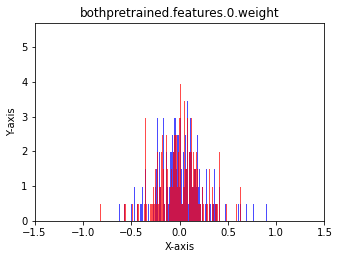

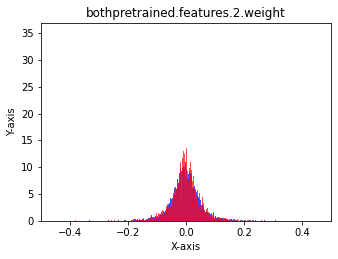

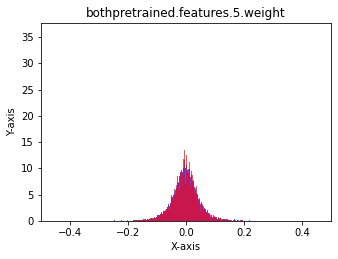

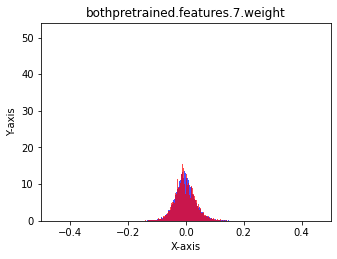

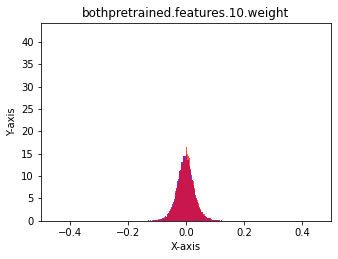

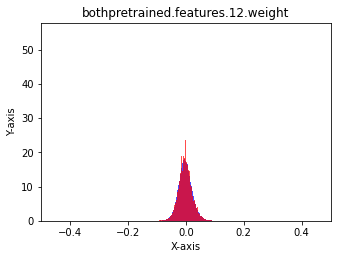

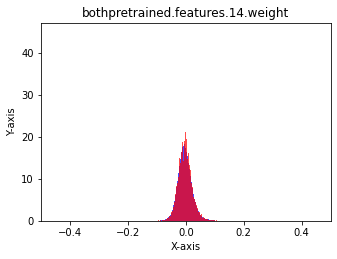

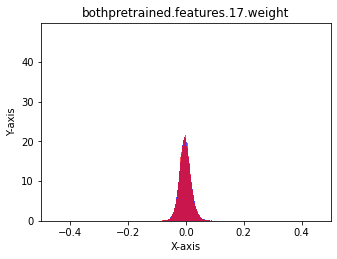

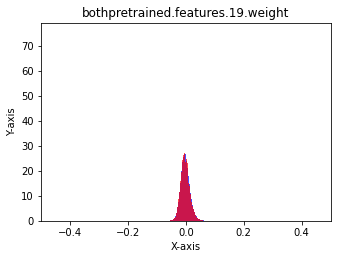

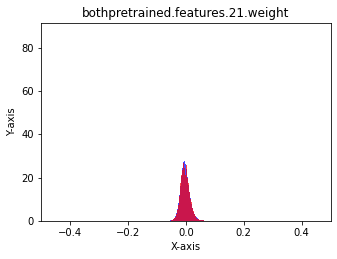

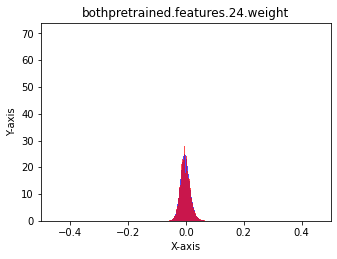

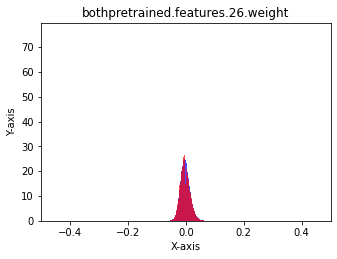

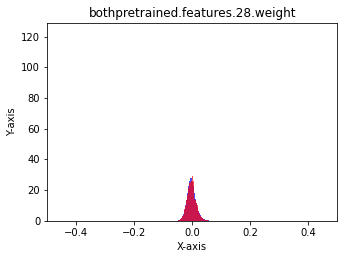

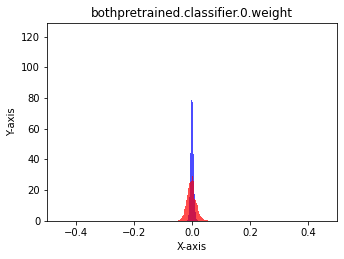

In [267]:
c = 0
num_bins = 2000
for each in weights_my_vgg16:
  if(c==14):
    break
  c += 1
  x = weights_my_vgg16[each]
  x_max = max(x)
  try:
    x_int8 = weights_my_vgg16_int8[each]
    x_max_int8 = max(x_int8)
  except:
    pass
  fig = plt.figure(figsize=(80,8))
  fig.add_subplot(2,13,c)
  n, bins, patches = plt.hist(x, num_bins, color ='blue',stacked = True	,density = 1, alpha = 0.7)
  n, bins, patches = plt.hist(x_int8, num_bins, color ='red',stacked = True	,density = 1,alpha = 0.7)
  plt.title("both"+each)
  if(c==1):
    plt.xlim(-1.5, 1.5)
  else:
    plt.xlim(-0.5,0.5)
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.show

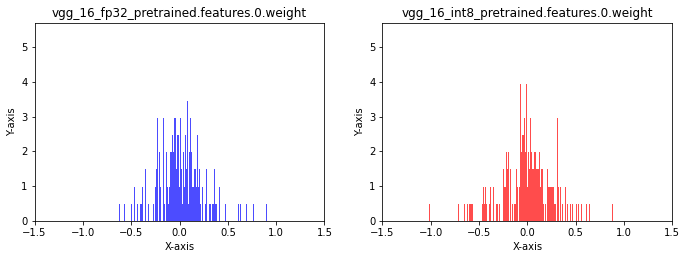

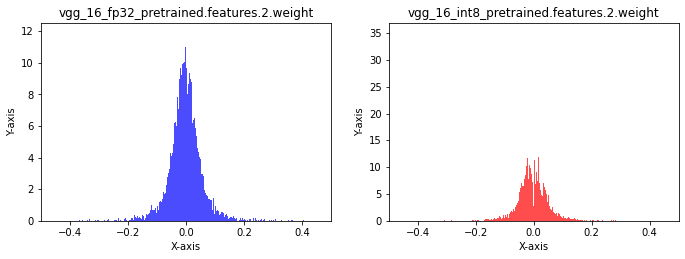

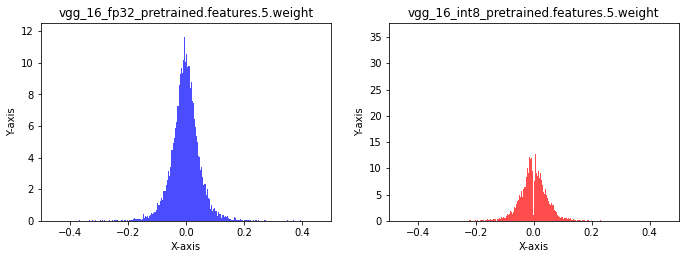

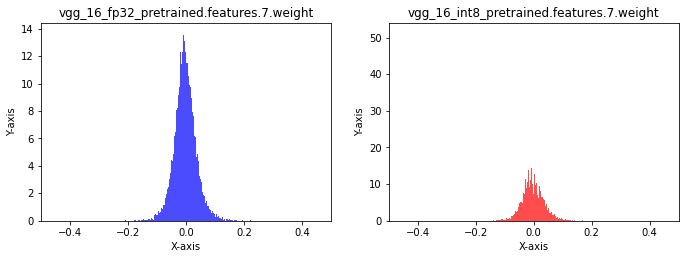

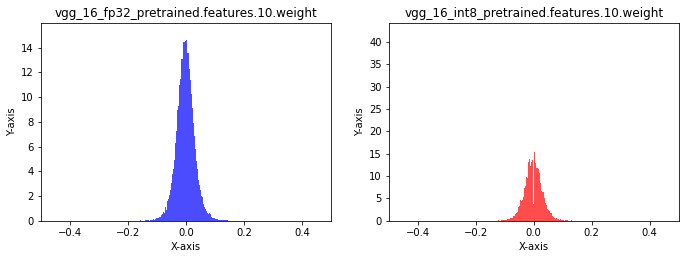

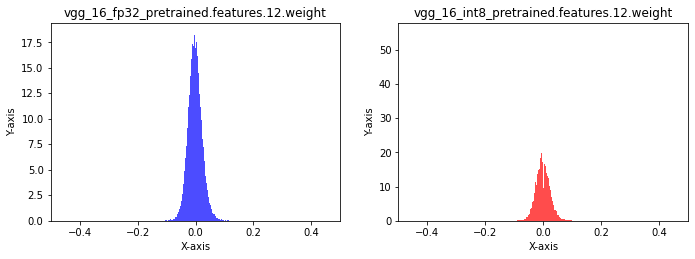

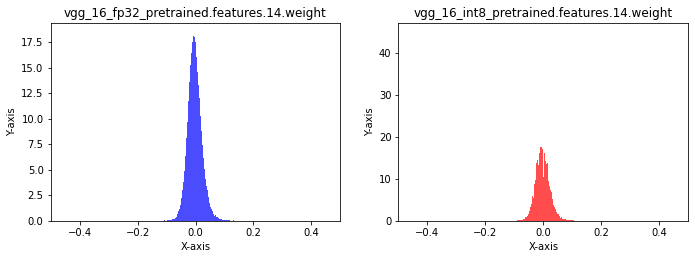

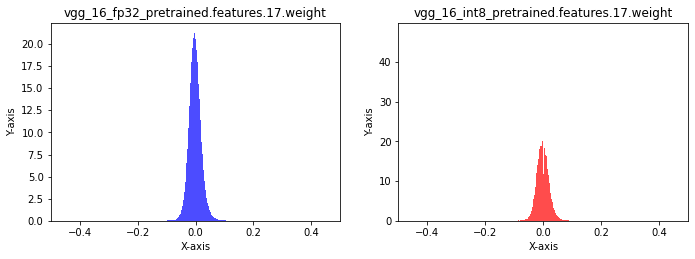

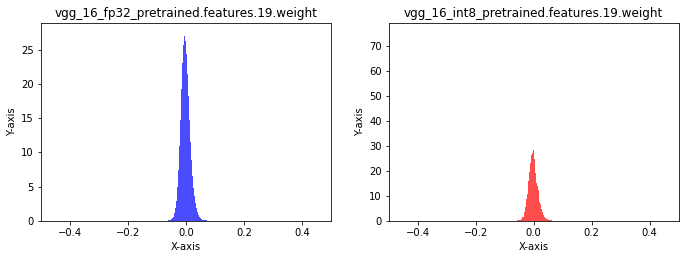

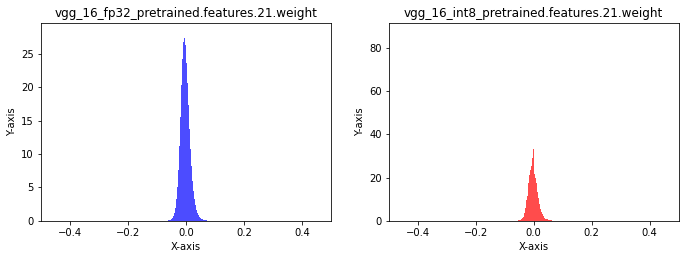

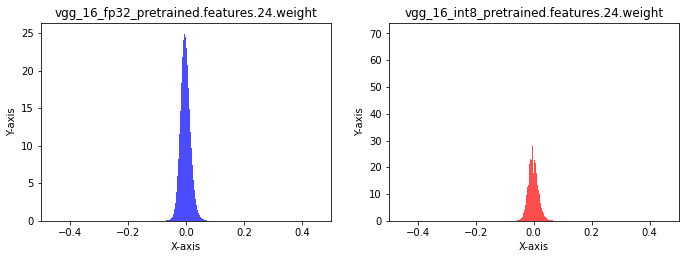

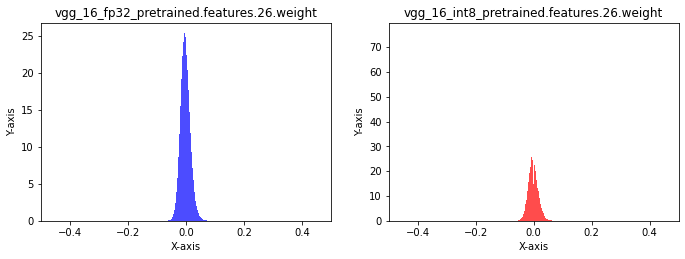

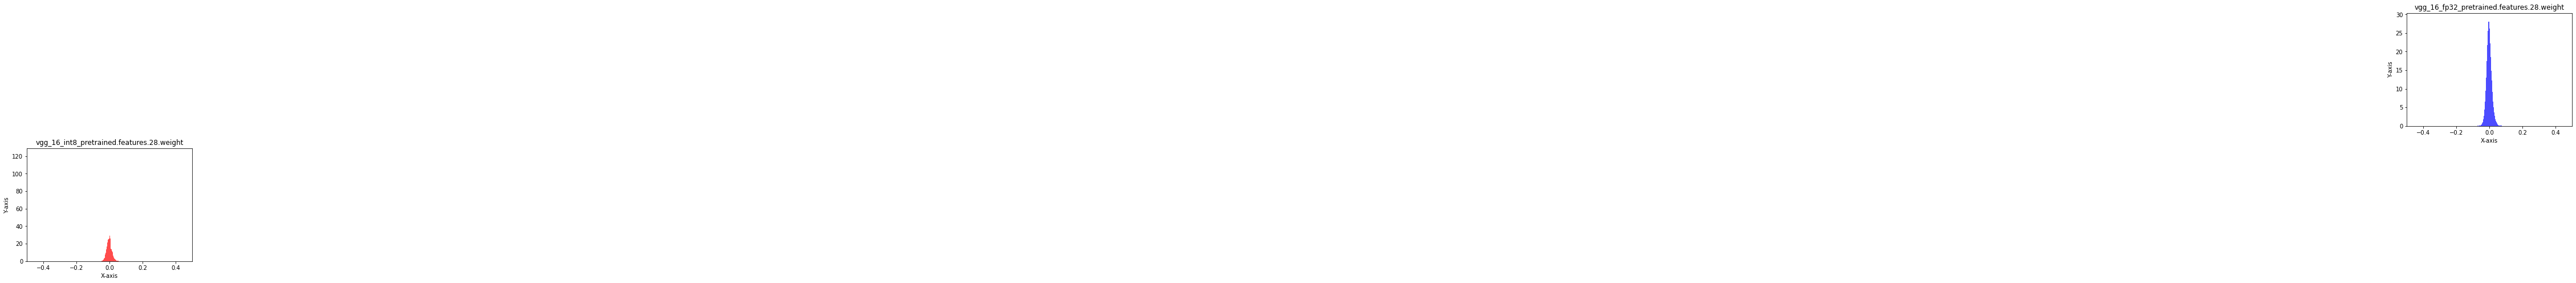

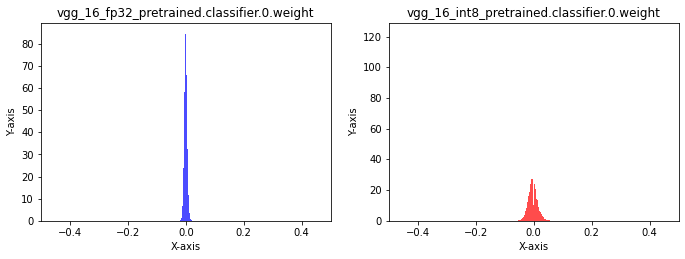

In [268]:
c = 0
num_bins = 2000
for each in weights_my_vgg16:
  if(c==14):
    break
  c += 1
  x = weights_my_vgg16[each]
  x_max = max(x)
  try:
    x_int8 = weights_my_vgg16_int8[each]
    x_max_int8 = max(x_int8)
  except:
    pass
  fig = plt.figure(figsize=(80,8))
  fig.add_subplot(2,13,c)
  n, bins, patches = plt.hist(x, num_bins, color ='blue',stacked = True	,density = 1, alpha = 0.7)
  plt.title("vgg_16_fp32_"+each)
  if(c==1):
    plt.xlim(-1.5, 1.5)
  else:
    plt.xlim(-0.5,0.5)
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  fig.add_subplot(2,13,c+1)
  n, bins, patches = plt.hist(x_int8, num_bins, color ='red',stacked = True	,density = 1,alpha = 0.7)
  plt.title("vgg_16_int8_"+each)
  if(c==1):
    plt.xlim(-1.5, 1.5)
  else:
    plt.xlim(-0.5,0.5)
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.show